Marilyn CHAHINE

<h1 style="text-align: center;">IAR - Micro-Project <br>Over-estimation bias with DDPG and TD3 on  LunarLander</h1>

In [52]:
#pip install stable-baselines3[extra]

In [53]:
#pip install swig==4.3.1

In [54]:
#pip install gymnasium[box2d]

In [123]:
import gymnasium as gym
from stable_baselines3 import DDPG
from stable_baselines3 import td3
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CallbackList
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import pickle
from scipy import stats

**Create environment**

In [62]:
# env has render disabled and is used during training 
# render_env has rendering enabled and is used during testing
env = gym.make("LunarLander-v3", render_mode = None, continuous=True)
render_env = gym.make("LunarLander-v3", render_mode = "human", continuous=True)

**Callback function that will be used to collect Q-values during training:**

In [63]:
class qvalue_tracking(BaseCallback):
    def __init__(self, env, eval_freq):
        super().__init__()
        self.env = env
        self.eval_freq = eval_freq
        self.q_values = []
        self.timesteps = []

    def _on_step(self):
        if self.n_calls % self.eval_freq == 0:
            obs, _ = self.env.reset()
            q_vals = []
            states_sampled = env.observation_space.shape[0]
            for _ in range(states_sampled):
                action, _ = self.model.predict(obs, deterministic=True)
                # compute Q(s,a)
                q = self.model.critic(torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(self.model.device),
                                      torch.tensor(action, dtype=torch.float32).unsqueeze(0).to(self.model.device))
                q_vals.append(q[0][0].item())
                obs, _, terminated, truncated, _ = self.env.step(action)
                if terminated or truncated:
                    obs, _ = self.env.reset()
            self.q_values.append(np.mean(q_vals))
            self.timesteps.append(self.num_timesteps)
        return True

<h2 style="text-align: center;"> Optimal hyperparameters </h2>

**Parameters definition**

In [64]:
# RL Baselines Zoo optimal parameters for both algoritms

noise_std = 0.1

n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=noise_std * np.ones(n_actions))

policy_kwargs = {
    'net_arch' : [400, 300] # one hidden layer of 400 nodes and another of 300 nodes 
}

parameters_model = {
    'env' : env,
    'policy' : "MlpPolicy",
    'learning_rate' : 0.001,
    'gamma' : 0.98,
    'buffer_size' : 200000,
    'learning_starts' : 10000,
    'action_noise' : action_noise,
    'gradient_steps' : 1,
    'train_freq' : 1,
    'policy_kwargs' : policy_kwargs,
}

In [65]:
total_timesteps = 200000
eval_freq = 1000

**DDPG: Optimal run**

In [ ]:
# run DDPG with optimal hyperparameters


# set the path to save the EvalCallback return in
save_path = "/home/marilynch/IAR"
file_name1 = "logs_DDPG_Optimal_timesteps" + str(total_timesteps) + "_step" +str(eval_freq)
logs_path1 = os.path.join(save_path, file_name1)
os.makedirs(logs_path1, exist_ok=True) 
os.chdir(save_path)  

# callbacks needed for ploting
q_callback_ddpg_optimal = qvalue_tracking(env=env, eval_freq=eval_freq)
avgreward_callback_ddpg_optimal = EvalCallback(env, best_model_save_path=logs_path1,
                             log_path=logs_path1, eval_freq=eval_freq, n_eval_episodes = 5,
                             deterministic=True, render=False)

callback_ddpg_optimal = CallbackList([q_callback_ddpg_optimal, avgreward_callback_ddpg_optimal])


# training
model_ddpg_optimal = DDPG(**parameters_model)
model_ddpg_optimal.learn(total_timesteps = total_timesteps, callback=callback_ddpg_optimal)


# testing
obs, _ = render_env.reset()
done = False
total_reward = 0

while not done:
    action, _ = model_ddpg_optimal.predict(obs)
    obs, reward, terminated, truncated, info = render_env.step(action)
    done = terminated or truncated
    total_reward += reward
    render_env.render()


# collect mean rewards and save qvalues
os.chdir(logs_path1)
with open("qvals_ddpg_optimal.pkl", "wb") as f:
    pickle.dump(q_callback_ddpg_optimal.q_values, f)
    
file_path = os.path.join(logs_path1, "evaluations.npz")
mean_rewards = np.load(file_path)

timesteps_ddpg_optimal = mean_rewards['timesteps']
mean_reward_ddpg_optimal = []
ep_length_ddpg_optimal = []

for i in range(len(mean_rewards['results'])):
    mean_reward_ddpg_optimal.append(np.mean(mean_rewards['results'][i]))
    ep_length_ddpg_optimal.append(np.mean(mean_rewards['ep_lengths'][i]))

**TD3: Optimal run**

In [ ]:
# run TD3 with optimal hyperparameters


# set the path to save the EvalCallback return in
save_path = "/home/marilynch/IAR"
file_name2 = "logs_TD3_Optimal_timesteps" + str(total_timesteps) + "_step" +str(eval_freq)
logs_path2 = os.path.join(save_path, file_name2)
os.makedirs(logs_path2, exist_ok=True) 
os.chdir(save_path)

# callbacks needed for ploting
q_callback_td3_optimal = qvalue_tracking(env=env, eval_freq=eval_freq)
avgreward_callback_td3_optimal = EvalCallback(env, best_model_save_path=logs_path2,
                             log_path=logs_path2, eval_freq=eval_freq, n_eval_episodes = 5,
                             deterministic=True, render=False)

callback_td3_optimal = CallbackList([q_callback_td3_optimal, avgreward_callback_td3_optimal])


# training
model_td3_optimal = DDPG(**parameters_model)
model_td3_optimal.learn(total_timesteps = total_timesteps, callback=callback_td3_optimal)


# testing
obs, _ = render_env.reset()
done = False
total_reward = 0

while not done:
    action, _ = model_td3_optimal.predict(obs)
    obs, reward, terminated, truncated, info = render_env.step(action)
    done = terminated or truncated
    total_reward += reward
    render_env.render()


# collect mean rewards and save qvalues
os.chdir(logs_path2)
with open("qvals_td3_optimal.pkl", "wb") as f:
    pickle.dump(q_callback_td3_optimal.q_values, f)
    
file_path = os.path.join(logs_path2, "evaluations.npz")
mean_rewards = np.load(file_path)

timesteps_td3_optimal = mean_rewards['timesteps']
mean_reward_td3_optimal = []

for i in range(len(mean_rewards['results'])):
    mean_reward_td3_optimal.append(np.mean(mean_rewards['results'][i]))

<h2 style="text-align: center;"> Potentially over-estimation producing (or amplifying) hyperparameters </h2>

**Parameters definition:**
<br> Changes made to the parameters and why

In [71]:
# modify the hyperparameters that are the most likely to produce an over-estimation bias

# increase initial action space noise (0.1 -> 0.2)
noise_std = 0.2

n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=noise_std * np.ones(n_actions))

policy_kwargs = {
    'net_arch' : [400, 300]
}

# increase learning rate (0.001 -> 0.005)
# reduce buffer size (200,000 -> 100,000)
parameters_model = {
    'env' : env,
    'policy' : "MlpPolicy",
    'learning_rate' : 0.005,
    'gamma' : 0.98,
    'buffer_size' : 100000,
    'learning_starts' : 10000,
    'action_noise' : action_noise,
    'gradient_steps' : 1,
    'train_freq' : 1,
    'policy_kwargs' : policy_kwargs
}

**DDPG: Non-optimal run**

In [ ]:
# run DDPG with non-optimal hyperparameters


# set the path to save the EvalCallback return in
save_path = "/home/marilynch/IAR"
file_name3 = "logs_DDPG_NonOptimal_timesteps" + str(total_timesteps) + "_step" +str(eval_freq)
logs_path3 = os.path.join(save_path, file_name3)
os.makedirs(logs_path3, exist_ok=True) 
os.chdir(save_path) 

# callbacks needed for ploting
q_callback_ddpg_nonoptimal = qvalue_tracking(env=env, eval_freq=eval_freq)
avgreward_callback_ddpg_nonoptimal = EvalCallback(env, best_model_save_path=logs_path3,
                             log_path=logs_path3, eval_freq=eval_freq, n_eval_episodes = 5,
                             deterministic=True, render=False)

callback_ddpg_nonoptimal = CallbackList([q_callback_ddpg_nonoptimal, avgreward_callback_ddpg_nonoptimal])


# training
model_ddpg_nonoptimal = DDPG(**parameters_model)
model_ddpg_nonoptimal.learn(total_timesteps = total_timesteps, callback=callback_ddpg_nonoptimal)


# testing
obs, _ = render_env.reset()
done = False
total_reward = 0

while not done:
    action, _ = model_ddpg_nonoptimal.predict(obs)
    obs, reward, terminated, truncated, info = render_env.step(action)
    done = terminated or truncated
    total_reward += reward
    render_env.render()


# collect mean rewards and save qvalues
os.chdir(logs_path3)
with open("qvals_ddpg_nonoptimal.pkl", "wb") as f:
    pickle.dump(q_callback_ddpg_nonoptimal.q_values, f)
    
file_path = os.path.join(logs_path3, "evaluations.npz")
mean_rewards = np.load(file_path)

timesteps_ddpg_nonoptimal = mean_rewards['timesteps']
mean_reward_ddpg_nonoptimal = []

for i in range(len(mean_rewards['results'])):
    mean_reward_ddpg_nonoptimal.append(np.mean(mean_rewards['results'][i]))

**TD3: Non-optimal run**

In [ ]:
# run TD3 with non-optimal hyperparameters


# set the path to save the EvalCallback return in
save_path = "/home/marilynch/IAR"
file_name4 = "logs_TD3_NonOptimal_timesteps" + str(total_timesteps) + "_step" +str(eval_freq)
logs_path4 = os.path.join(save_path, file_name4)
os.makedirs(logs_path4, exist_ok=True) 
os.chdir(save_path) 

# callbacks needed for ploting
q_callback_td3_nonoptimal = qvalue_tracking(env=env, eval_freq=eval_freq)
avgreward_callback_td3_nonoptimal = EvalCallback(env, best_model_save_path=logs_path4,
                             log_path=logs_path4, eval_freq=eval_freq, n_eval_episodes = 5,
                             deterministic=True, render=False)

callback_td3_nonoptimal = CallbackList([q_callback_td3_nonoptimal, avgreward_callback_td3_nonoptimal])


# training
model_td3_nonoptimal = DDPG(**parameters_model)
model_td3_nonoptimal.learn(total_timesteps = total_timesteps, callback=callback_td3_nonoptimal)


# testing
obs, _ = render_env.reset()
done = False
total_reward = 0

while not done:
    action, _ = model_td3_nonoptimal.predict(obs)
    obs, reward, terminated, truncated, info = render_env.step(action)
    done = terminated or truncated
    total_reward += reward
    render_env.render()


# collect mean rewards and save qvalues
os.chdir(logs_path4)
with open("qvals_td3_nonoptimal.pkl", "wb") as f:
    pickle.dump(q_callback_td3_nonoptimal.q_values, f)
    
file_path = os.path.join(logs_path4, "evaluations.npz")
mean_rewards = np.load(file_path)

timesteps_td3_nonoptimal = mean_rewards['timesteps']
mean_reward_td3_nonoptimal = []

for i in range(len(mean_rewards['results'])):
    mean_reward_td3_nonoptimal.append(np.mean(mean_rewards['results'][i]))

<h2 style="text-align: center;"> Producing the figures and metrics </h2>

**Over-estimation bias measurment: mean Q values over training timesteps**

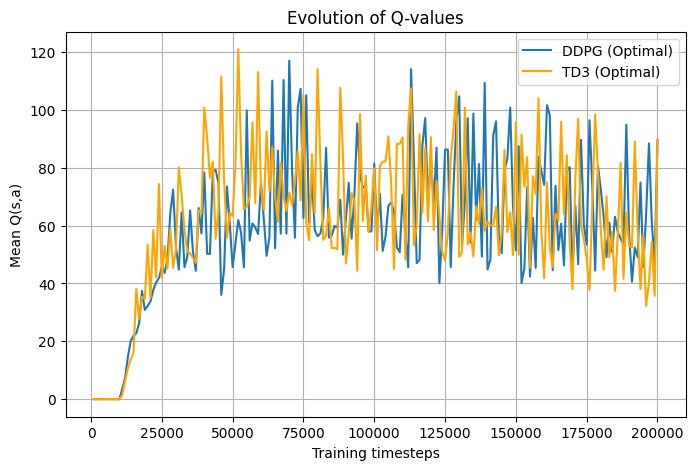

In [107]:
plt.figure(figsize=(8,5))
plt.plot(q_callback_ddpg_optimal.timesteps, q_callback_ddpg_optimal.q_values, label = "DDPG (Optimal)", color="C0")
plt.plot(q_callback_td3_optimal.timesteps, q_callback_td3_optimal.q_values, label = "TD3 (Optimal)", color="orange")
plt.xlabel('Training timesteps')
plt.ylabel('Mean Q(s,a)')
plt.title('Evolution of Q-values')
plt.legend()
plt.grid(True)
plt.show()

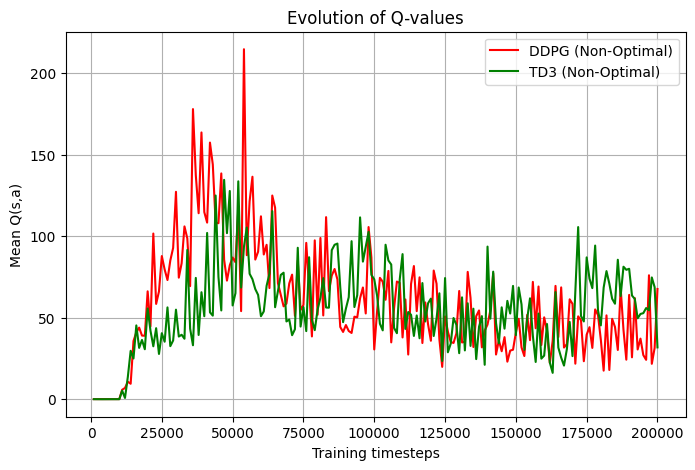

In [108]:
plt.figure(figsize=(8,5))
plt.plot(q_callback_ddpg_nonoptimal.timesteps, q_callback_ddpg_nonoptimal.q_values, label = "DDPG (Non-Optimal)", color="red")
plt.plot(q_callback_td3_nonoptimal.timesteps, q_callback_td3_nonoptimal.q_values, label = "TD3 (Non-Optimal)", color="green")
plt.xlabel('Training timesteps')
plt.ylabel('Mean Q(s,a)')
plt.title('Evolution of Q-values')
plt.legend()
plt.grid(True)
plt.show()

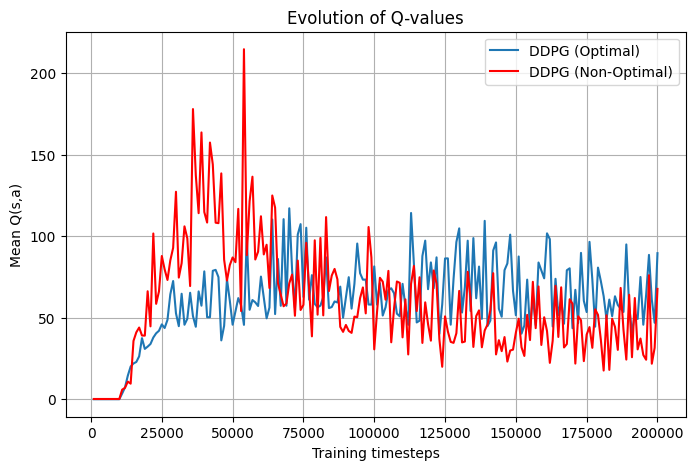

In [109]:
plt.figure(figsize=(8,5))
plt.plot(q_callback_ddpg_optimal.timesteps, q_callback_ddpg_optimal.q_values, label = "DDPG (Optimal)", color="C0")
plt.plot(q_callback_ddpg_nonoptimal.timesteps, q_callback_ddpg_nonoptimal.q_values, label = "DDPG (Non-Optimal)", color="red")
plt.xlabel('Training timesteps')
plt.ylabel('Mean Q(s,a)')
plt.title('Evolution of Q-values')
plt.legend()
plt.grid(True)
plt.show()

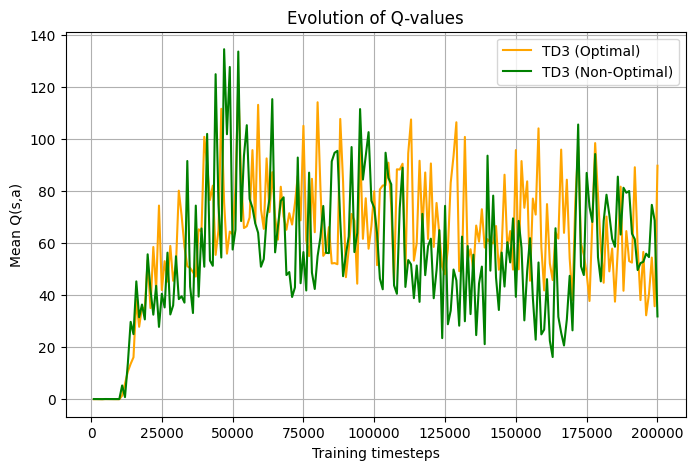

In [110]:
plt.figure(figsize=(8,5))
plt.plot(q_callback_td3_optimal.timesteps, q_callback_td3_optimal.q_values, label = "TD3 (Optimal)", color="orange")
plt.plot(q_callback_td3_nonoptimal.timesteps, q_callback_td3_nonoptimal.q_values, label = "TD3 (Non-Optimal)", color="green")
plt.xlabel('Training timesteps')
plt.ylabel('Mean Q(s,a)')
plt.title('Evolution of Q-values')
plt.legend()
plt.grid(True)
plt.show()

**Performance measurment: learning curve**

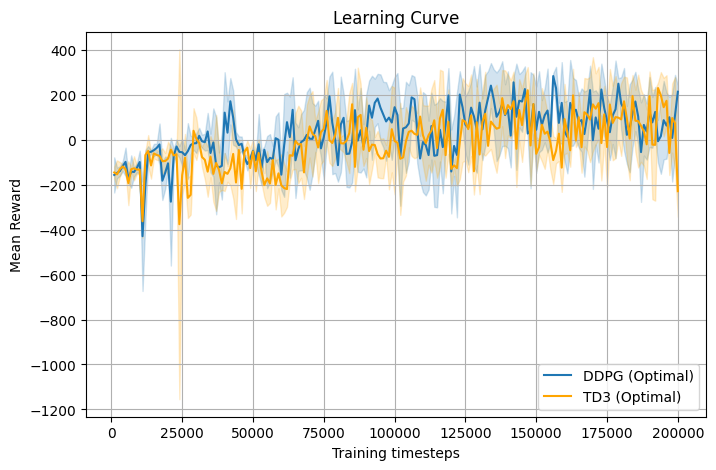

In [113]:
plt.figure(figsize=(8,5))

# extract values needed to plot variance
file_path1 = os.path.join(logs_path1, "evaluations.npz")
mean_rewards1 = np.load(file_path1)
learningcurve_var_ddpg_optimal = mean_rewards1['results']
std_ddpg_optimal = [np.std(evalpt) for evalpt in learningcurve_var_ddpg_optimal]

file_path2 = os.path.join(logs_path2, "evaluations.npz")
mean_rewards2 = np.load(file_path2)
learningcurve_var_td3_optimal = mean_rewards2['results']
std_td3_optimal = [np.std(evalpt) for evalpt in learningcurve_var_td3_optimal]


plt.plot(timesteps_ddpg_optimal, mean_reward_ddpg_optimal, label = "DDPG (Optimal)", color="C0")
plt.fill_between(timesteps_ddpg_optimal, np.array(mean_reward_ddpg_optimal) - np.array(std_ddpg_optimal),
                 np.array(mean_reward_ddpg_optimal) + np.array(std_ddpg_optimal),
                 color='C0', alpha=0.2)


plt.plot(timesteps_td3_optimal, mean_reward_td3_optimal, label = "TD3 (Optimal)", color="orange")
plt.fill_between(timesteps_td3_optimal, np.array(mean_reward_td3_optimal) - np.array(std_td3_optimal),
                 np.array(mean_reward_td3_optimal) + np.array(std_td3_optimal),
                 color='orange', alpha=0.2)


plt.xlabel('Training timesteps')
plt.ylabel('Mean Reward')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

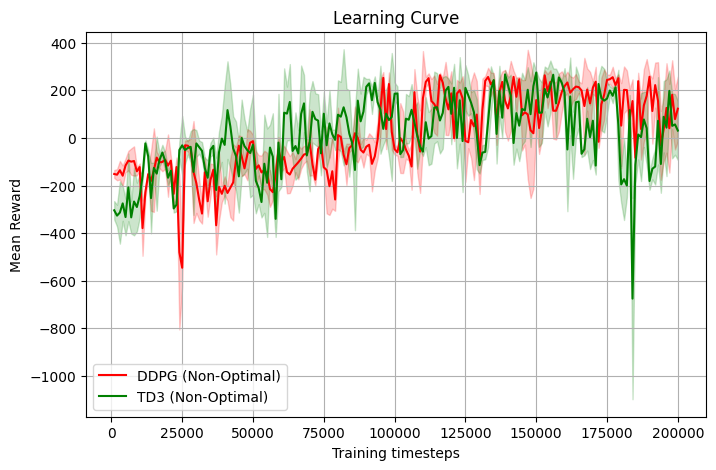

In [114]:
plt.figure(figsize=(8,5))

# extract values needed to plot variance
file_path3 = os.path.join(logs_path3, "evaluations.npz")
mean_rewards3 = np.load(file_path3)
learningcurve_var_ddpg_nonoptimal = mean_rewards3['results']
std_ddpg_nonoptimal = [np.std(evalpt) for evalpt in learningcurve_var_ddpg_nonoptimal]

file_path4 = os.path.join(logs_path4, "evaluations.npz")
mean_rewards4 = np.load(file_path4)
learningcurve_var_td3_nonoptimal = mean_rewards4['results']
std_td3_nonoptimal = [np.std(evalpt) for evalpt in learningcurve_var_td3_nonoptimal]


plt.plot(timesteps_ddpg_nonoptimal, mean_reward_ddpg_nonoptimal, label = "DDPG (Non-Optimal)", color="red")
plt.fill_between(timesteps_ddpg_nonoptimal, np.array(mean_reward_ddpg_nonoptimal) - np.array(std_ddpg_nonoptimal),
                 np.array(mean_reward_ddpg_nonoptimal) + np.array(std_ddpg_nonoptimal),
                 color='red', alpha=0.2)


plt.plot(timesteps_td3_nonoptimal, mean_reward_td3_nonoptimal, label = "TD3 (Non-Optimal)", color="green")
plt.fill_between(timesteps_td3_nonoptimal, np.array(mean_reward_td3_nonoptimal) - np.array(std_td3_nonoptimal),
                 np.array(mean_reward_td3_nonoptimal) + np.array(std_td3_nonoptimal),
                 color='green', alpha=0.2)



plt.xlabel('Training timesteps')
plt.ylabel('Mean Reward')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

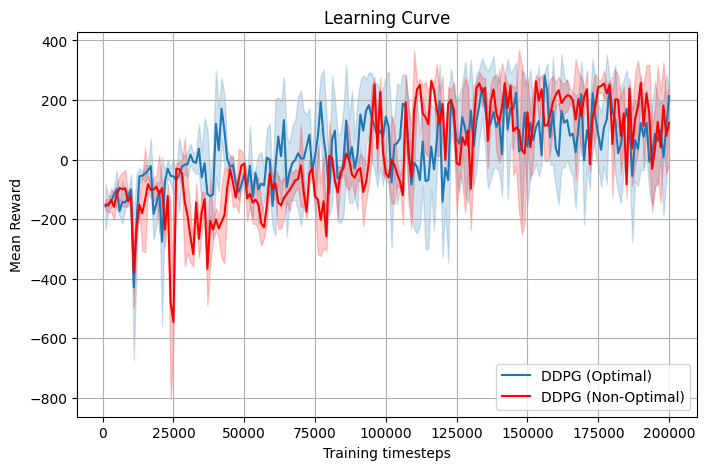

In [115]:
plt.figure(figsize=(8,5))

# extract values needed to plot variance
file_path1 = os.path.join(logs_path1, "evaluations.npz")
mean_rewards1 = np.load(file_path1)
learningcurve_var_ddpg_optimal = mean_rewards1['results']
std_ddpg_optimal = [np.std(evalpt) for evalpt in learningcurve_var_ddpg_optimal]


file_path3 = os.path.join(logs_path3, "evaluations.npz")
mean_rewards3 = np.load(file_path3)
learningcurve_var_ddpg_nonoptimal = mean_rewards3['results']
std_ddpg_nonoptimal = [np.std(evalpt) for evalpt in learningcurve_var_ddpg_nonoptimal]


plt.plot(timesteps_ddpg_optimal, mean_reward_ddpg_optimal, label = "DDPG (Optimal)", color="C0")
plt.fill_between(timesteps_ddpg_optimal, np.array(mean_reward_ddpg_optimal) - np.array(std_ddpg_optimal),
                 np.array(mean_reward_ddpg_optimal) + np.array(std_ddpg_optimal),
                 color='C0', alpha=0.2)


plt.plot(timesteps_ddpg_nonoptimal, mean_reward_ddpg_nonoptimal, label = "DDPG (Non-Optimal)", color="red")
plt.fill_between(timesteps_ddpg_nonoptimal, np.array(mean_reward_ddpg_nonoptimal) - np.array(std_ddpg_nonoptimal),
                 np.array(mean_reward_ddpg_nonoptimal) + np.array(std_ddpg_nonoptimal),
                 color='red', alpha=0.2)


plt.xlabel('Training timesteps')
plt.ylabel('Mean Reward')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

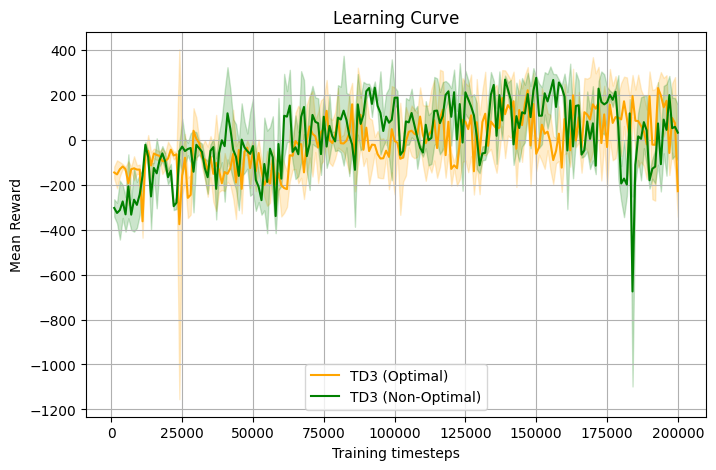

In [116]:
plt.figure(figsize=(8,5))

# extract values needed to plot variance
file_path2 = os.path.join(logs_path2, "evaluations.npz")
mean_rewards2 = np.load(file_path2)
learningcurve_var_td3_optimal = mean_rewards2['results']
std_td3_optimal = [np.std(evalpt) for evalpt in learningcurve_var_td3_optimal]

file_path4 = os.path.join(logs_path4, "evaluations.npz")
mean_rewards4 = np.load(file_path4)
learningcurve_var_td3_nonoptimal = mean_rewards4['results']
std_td3_nonoptimal = [np.std(evalpt) for evalpt in learningcurve_var_td3_nonoptimal]


plt.plot(timesteps_td3_optimal, mean_reward_td3_optimal, label = "TD3 (Optimal)", color="orange")
plt.fill_between(timesteps_td3_optimal, np.array(mean_reward_td3_optimal) - np.array(std_td3_optimal),
                 np.array(mean_reward_td3_optimal) + np.array(std_td3_optimal),
                 color='orange', alpha=0.2)

plt.plot(timesteps_td3_nonoptimal, mean_reward_td3_nonoptimal, label = "TD3 (Non-Optimal)", color="green")
plt.fill_between(timesteps_td3_nonoptimal, np.array(mean_reward_td3_nonoptimal) - np.array(std_td3_nonoptimal),
                 np.array(mean_reward_td3_nonoptimal) + np.array(std_td3_nonoptimal),
                 color='green', alpha=0.2)


plt.xlabel('Training timesteps')
plt.ylabel('Mean Reward')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [122]:
# calculating performance of each model:
performance_ddpg_optimal = mean_reward_ddpg_optimal[-2]
performance_td3_optimal = mean_reward_td3_optimal[-2]
performance_ddpg_nonoptimal = mean_reward_ddpg_nonoptimal[-2]
performance_td3_nonoptimal = mean_reward_td3_nonoptimal[-2]
print(performance_ddpg_optimal)
print(performance_td3_optimal)
print(performance_ddpg_nonoptimal)
print(performance_td3_nonoptimal)

107.72093654279638
73.15417399493428
78.88581883008344
56.79995020533575


In [124]:
print(stats.ttest_ind(learningcurve_var_ddpg_optimal[-2], learningcurve_var_ddpg_nonoptimal[-2]))

TtestResult(statistic=np.float64(0.26151033376998084), pvalue=np.float64(0.8003057263485506), df=np.float64(8.0))


In [125]:
print(stats.ttest_ind(learningcurve_var_td3_optimal[-2], learningcurve_var_td3_nonoptimal[-2]))

TtestResult(statistic=np.float64(0.13555000493798053), pvalue=np.float64(0.8955256905375327), df=np.float64(8.0))


In [126]:
print(stats.ttest_ind(learningcurve_var_td3_optimal[-2], learningcurve_var_td3_nonoptimal[-2]))

TtestResult(statistic=np.float64(0.13555000493798053), pvalue=np.float64(0.8955256905375327), df=np.float64(8.0))
